In [58]:
!pip install pyspark
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install sklearn_pandas


In [60]:
#Used libraries
#sklearn and sklearn_pandas must be installed seperately
import pandas as pd
import numpy
import matplotlib as matPlot
import matplotlib.pyplot as pyPlot
import seaborn as sns
import sklearn as sk
from scipy.stats import f_oneway
import statsmodels.api as sma
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pyspark.sql import SparkSession
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, FunctionTransformer, Binarizer, StandardScaler, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn_pandas import DataFrameMapper
import sklearn_pandas as skp

In [37]:
#creation of spark context used later on
spark = SparkSession.builder.getOrCreate()
#Changing some parameters of matPlot.rc for readability
PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="ticks")
matPlot.rc('ytick.major', width=0.2)
matPlot.rc('font', family='Arial', weight='400', size=10)
matPlot.rc('text', color='#282828')
matPlot.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
matPlot.rc('patch', linewidth=0)
matPlot.rc('xtick.major', width=0.2)

In [18]:
master_df = pd.read_csv("USvideos.csv")
#master_df = pd.read_csv("CAvideos.csv")
#master_df = pd.read_csv("DEvideos.csv")
#master_df = pd.read_csv("FRvideos.csv")
#master_df = pd.read_csv("GBvideos.csv")
#master_df = pd.read_csv("INvideos.csv")

In [19]:
#Data clearning that removes null results from "Description"
#All other columns are same length of results aside from "description"
master_df[master_df["description"].apply(lambda x:pd.isna(x))].head(3)
#replaces nulls with empty strings
master_df["description"] = master_df["description"].fillna(value="")

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
42,NZFhMSgbKKM,17.14.11,Dennis Smith Jr. and LeBron James go back and ...,Ben Rohrbach,17,2017-11-13T15:11:00.000Z,[none],945,7,5,8,https://i.ytimg.com/vi/NZFhMSgbKKM/default.jpg,False,False,False,NaN
47,sbcbvuitiTc,17.14.11,Stephon Marbury and Jimmer Fredette fight in C...,NBA Highlights · YouTube,17,2017-11-10T18:23:05.000Z,"NBA|""Basketball""|""Sports""",956169,2017,2425,1447,https://i.ytimg.com/vi/sbcbvuitiTc/default.jpg,False,False,False,NaN
175,4d07RXYLsJE,17.14.11,Sphaera - demonstrating interaction,Jenny Hanell,28,2017-11-04T20:48:16.000Z,[none],1827,3,0,2,https://i.ytimg.com/vi/4d07RXYLsJE/default.jpg,False,False,False,NaN


In [21]:
#overview of the numerical columns
#category id is numerical but they are associated with strings, but they're much easier to use in a numerical form
pd.options.display.float_format = '{:.2f}'.format
master_df.describe()

,category_id,views,likes,dislikes,comment_count
count,40949.00,40949.00,40949.00,40949.00,40949.00
mean,19.97,2360784.64,74266.70,3711.40,8446.80
std,7.57,7394113.76,228885.34,29029.71,37430.49
min,1.00,549.00,0.00,0.00,0.00
25%,17.00,242329.00,5424.00,202.00,614.00
50%,24.00,681861.00,18091.00,631.00,1856.00
75%,25.00,1823157.00,55417.00,1938.00,5755.00
max,43.00,225211923.00,5613827.00,1674420.00,1361580.00


In [24]:
#Begining of ANOVA analysis using scypy

In [24]:
#applying initial weights as extra columns on the end of the panda 
master_df['likes_weighted'] = (master_df['views']*master_df['likes'])
master_df['dislikes_weighted'] = (master_df['views']*master_df['dislikes'])

In [24]:
f_oneway(master_df['likes'], master_df['dislikes'])

F_onewayResult(statistic=3829.4479417776474, pvalue=0.0)

In [25]:
f_oneway(master_df['likes'], master_df['views'])

F_onewayResult(statistic=3912.049311118326, pvalue=0.0)

In [26]:
f_oneway(master_df['likes'], master_df['category_id'])

F_onewayResult(statistic=4308.8563391213, pvalue=0.0)

In [27]:
f_oneway(master_df['dislikes'], master_df['comment_count'])

F_onewayResult(statistic=409.24157525113606, pvalue=8.945311002067567e-91)

###### f_oneway(master_df['dislikes'], master_df['category_id'])

In [31]:
f_oneway(master_df['likes_weighted'], master_df['dislikes'], master_df['likes'], master_df['comment_count'])

F_onewayResult(statistic=216.83641107150873, pvalue=2.1470993910431132e-140)

In [52]:
#Tukey multi test for variance
#Has a problem with crashing if weights method is applied multiple times
#Reseting the index occasionally works if that occurs, but usually has to be run from the beginning
test_df = pd.melt(master_df.reset_index(), id_vars=['index'], value_vars=['likes', 'likes_weighted', 'dislikes', 'dislikes_weighted'])
tukey = pairwise_tukeyhsd(endog=master_df['views'], groups=test_df, alpha=0.5)

ValueError: data has 40949 elements and groups has 163796

In [32]:
f_oneway(master_df['likes_weighted'], master_df['comment_count'])

In [34]:
f_oneway(master_df['dislikes_weighted'], master_df['comment_count'])

F_onewayResult(statistic=71.53189172340497, pvalue=2.7722529274355706e-17)

In [23]:
#Counts the length of the tags column and creates a new column for them
master_df["tags_count"] = master_df["tags"].apply(lambda x: len(x))

In [46]:
#Converting the finished panda to an RDD and a PySpark Dataframe for predictive testing
#Can have issues establishing the PySpark worker if it's been run before in the same instance
output_rdd = spark.sparkContext.parallelize(master_df)
output_df = spark.createDataFrame(output_rdd)
output_df.printSchema()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1.0 (TID 1) (Fenrir executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 14 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 14 more


H:\Users\Greg\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


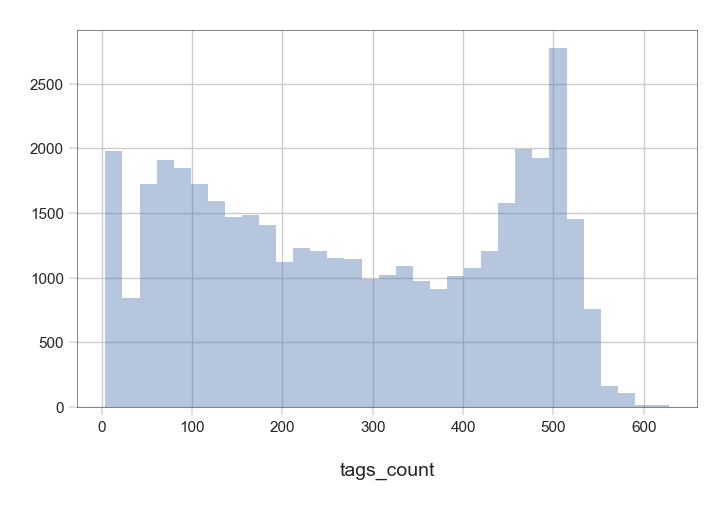

In [23]:
#visualization of the tags_count column
#many of these were used looking for relationships, but were replaced with scatterplots to look for outliers
fig, ax = pyPlot.subplots()
graph = sns.distplot(master_df["tags_count"], kde=False, rug=False, ax=ax)

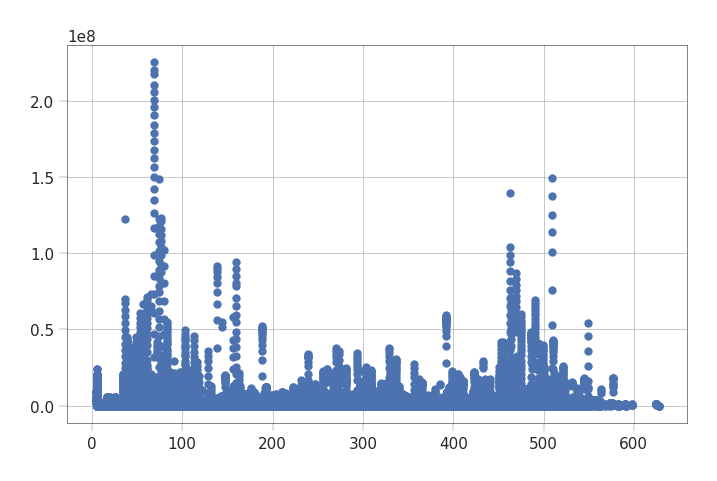

In [ ]:
#Example of the scatterplots used for initial analysis
fig, ax = pyPlot.subplots()
graph = ax.scatter(x=master_df['tags_count'], y=master_df['views'])

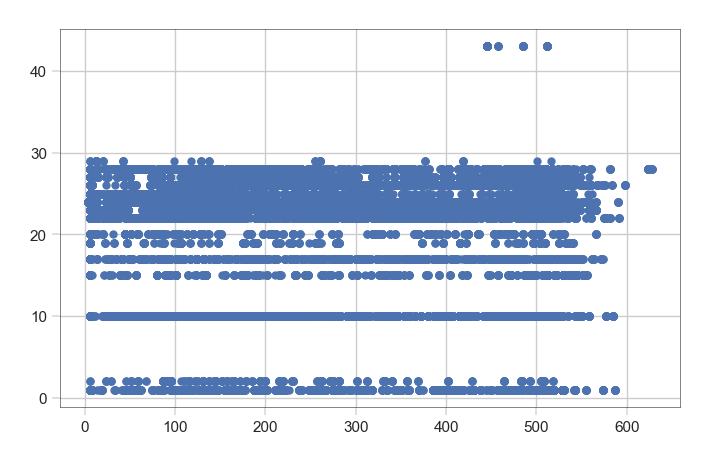

In [64]:
#slices tag strings up into individual tags
master_df['tag_number'] = master_df['tags'].apply(lambda x: x.split('|')).head()
master_df['tag_number'].head()
f_oneway(master_df['tags_count'], master_df['comment_count'])
#visualizes a scatterplot that does not show statistical significance
pyPlot.scatter(master_df['tags_count'],master_df['category_id'])


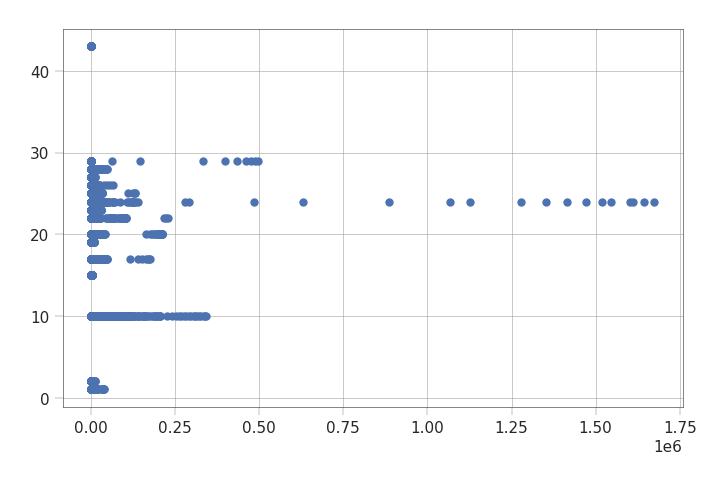

In [ ]:
#An example of a comparison with very clear outliers
pyPlot.scatter(master_df['dislikes'],master_df['category_id'])
pyPlot.show()


In [ ]:
#Testing datasplitting for sklearn predictive model
temp1 = master_df.groupby('category_id')
temp2 = temp1['category_id','dislikes', 'likes'].max()
temp2.sort_values('dislikes',ascending=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,category_id,dislikes,likes
category_id,,,
24,24,1674420,3093544
29,29,497847,1988746
10,10,343541,5613827
22,22,228426,2032463
20,20,212976,444203
17,17,176903,1121217
25,25,132439,163338
26,26,66632,605954
28,28,47469,564804


In [65]:
#Verification sanity check to make sure data columns match in count of non-nulls
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

In [66]:
#sklearn import fot Cheybyshev analysis and linear regression mapping
from sklearn_pandas import DataFrameMapper
import sklearn.preprocessing, sklearn.decomposition, sklearn.linear_model, sklearn.pipeline, sklearn.metrics, sklearn.compose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [67]:
#mapping of partial dataframe for comparitive analysis
mapper = DataFrameMapper([('likes', None),('dislikes', None)])
mapped_df = mapper.fit_transform(master_df)
mapped_df

array([[ 57527,   2966],
       [ 97185,   6146],
       [146033,   5339],
       ...,
       [ 48068,   1032],
       [192957,   2846],
       [357079, 212976]], dtype=int64)

In [68]:
x,y = mapped_df.T

#model = LogisticRegression(solver='liblinear', random_state=0)
#model.intercept_
#model.coef_


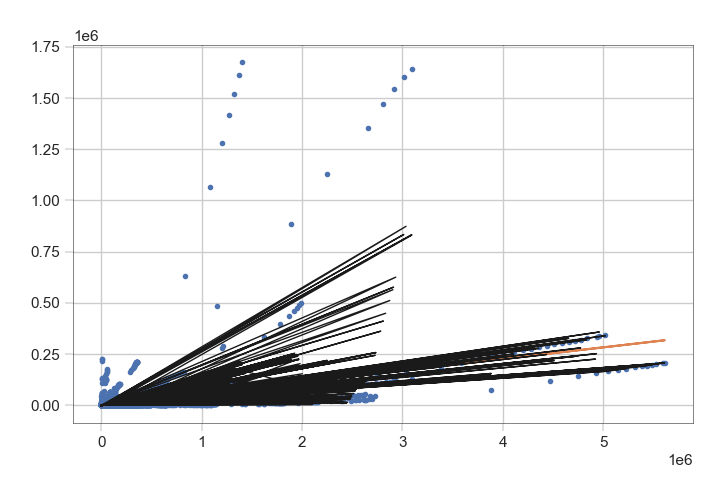

In [69]:
from sklearn.linear_model import LinearRegression
from numpy.polynomial import Chebyshev
#plots trending data points
k, d = numpy.polyfit(x, y, 1)
#inbuilt linear regression equation often returned errors so the y prediction is found useing a hard coded equation instead 
y_pred = k*x + d
#Plots provided data as a scatterplot
pyPlot.plot(x, y, '.')
#plots in singular line of best fit (in orange)
pyPlot.plot(x, y_pred)
#fits the Chebyshev analysis on 60 sample pairs (shown in black)
c = Chebyshev.fit(x,y, 60)
#plots all results of Chebyshev analysis
pyPlot.plot(x, c(x), 'k-', lw=1)
